# Multi-Resource Scheduling

Tasks require multiple resources at the same time. We model each
resource with a cumulative function.


## Problem Description

Tasks require multiple resources at the same time (workers, machines, budget).
Each resource has a capacity and each task has a demand.

Objective: minimize makespan.


## Mathematical Model

Definitions:
- $I_i: \text{task interval}, \quad d_{i,r}: \text{demand}, \quad C_r: \text{capacity}$

Constraints:
- $ \sum_i d_{i,r} \cdot active_i(t) \le C_r \quad \forall r, \forall t$

Objective:
- $\min \max_i end_i$

## Imports


In [1]:
# Imports
from pycsp3 import *
from pycsp3_scheduling import *  

## Problem Data


In [2]:
resource_capacities = {
    'workers': 5,
    'machines': 2,
    'budget': 100,
}

multi_resource_tasks = [
    ('build', 10, 3, 1, 50),
    ('test', 5, 2, 1, 20),
    ('deploy', 3, 1, 0, 30),
    ('review', 4, 2, 0, 10),
    ('analyze', 6, 1, 1, 40),
]

horizon = sum(d for _, d, *_ in multi_resource_tasks)


## Build the Model


In [3]:
clear()
from pycsp3_scheduling.variables.interval import clear_interval_registry
clear_interval_registry()

intervals = {}
for name, duration, workers, machines, budget in multi_resource_tasks:
    intervals[name] = IntervalVar(
        start=(0, horizon),
        end=(0, horizon),
        size=duration,
        name=name
    )


In [4]:
worker_usage = None
machine_usage = None
budget_usage = None

for name, duration, workers, machines, budget in multi_resource_tasks:
    iv = intervals[name]
    if workers > 0:
        p = pulse(iv, workers)
        worker_usage = p if worker_usage is None else worker_usage + p
    if machines > 0:
        p = pulse(iv, machines)
        machine_usage = p if machine_usage is None else machine_usage + p
    if budget > 0:
        p = pulse(iv, budget)
        budget_usage = p if budget_usage is None else budget_usage + p

# Constrain resource usage: 0 <= usage <= capacity at all times
satisfy(cumul_range(worker_usage, 0, resource_capacities['workers']))
satisfy(cumul_range(machine_usage, 0, resource_capacities['machines']))
satisfy(cumul_range(budget_usage, 0, resource_capacities['budget']))

cumulative(origins:[iv_s_0, iv_s_1, iv_s_2, iv_s_3, iv_s_4], lengths:[10, 5, 3, 4, 6], heights:[50, 20, 30, 10, 40], condition:(le,100))

In [5]:
objective_expr = Maximum(end_time(intervals[name]) for name in intervals)
minimize(objective_expr)


## Solve


In [6]:
result = solve()

if result in (SAT, OPTIMUM):
    print("Solution found." + (" (Optimal)" if result == OPTIMUM else ""))
    for name in intervals:
        val = interval_value(intervals[name])
        print(f"{name}: [{val.start}, {val.end})")
    makespan = max(interval_value(intervals[name]).end for name in intervals)
    print(f"Makespan: {makespan}")
else:
    print("No solution found.")


Solution found. (Optimal)
build: [0, 10)
test: [0, 5)
deploy: [5, 8)
review: [10, 14)
analyze: [8, 14)
Makespan: 14


## Stats


In [7]:
print("Model statistics:", model_statistics())
if result in (SAT, OPTIMUM):
    objective_value = globals().get("makespan")
    print("Solution statistics:", solution_statistics(status=result, objective=objective_value))


Model statistics: ModelStatistics(nb_interval_vars=5, nb_optional_interval_vars=0, nb_sequences=0, nb_sequences_with_types=0, nb_cumul_functions=0, nb_state_functions=0)
Solution statistics: SolutionStatistics(status=OPTIMUM, objective_value=14, solve_time=None, nb_interval_vars=5, nb_intervals_present=5, nb_intervals_absent=0, min_start=0, max_end=14, makespan=14, span=14)


## Visualization


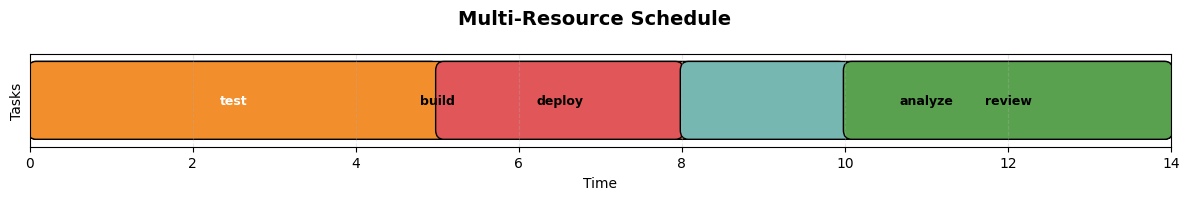

In [8]:
if result in (SAT, OPTIMUM):
    visu.reset()
    makespan = max(interval_value(intervals[name]).end for name in intervals)
    visu.timeline("Multi-Resource Schedule", origin=0, horizon=makespan)
    visu.panel("Tasks")

    schedule = []
    for idx, name in enumerate(intervals):
        val = interval_value(intervals[name])
        schedule.append((val.start, val.end, name, idx))
    schedule.sort()

    for start, end, name, idx in schedule:
        visu.interval(start, end, name, color=idx)

    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available).")
